In [1]:
import sys
sys.path.append("../misc");
import onnx
import torchvision
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torchvision import transforms
from PIL import Image
from utils import load_class_label,extract_cifar,unpickle,fuse_single_conv_bn_pair
import torch.nn as nn
from utils import DataShaper, count_parameters
import os
import math
import numpy as np
from numpy import load
import numpy
torch.manual_seed(0)
import resnet_projected as res
import time
from brevitas.nn import QuantConv2d, QuantIdentity, QuantReLU
from brevitas.quant.fixed_point import Int8ActPerTensorFixedPoint, Int8WeightPerTensorFixedPoint,Uint8ActPerTensorFixedPoint
from brevitas.graph.target.flexml import preprocess_for_flexml_quantize
from brevitas_examples.imagenet_classification.ptq.ptq_common import quantize_model
import torch.utils.data as data_utils
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate
from brevitas_examples.imagenet_classification.ptq.ptq_common import calibrate_bn
from brevitas_examples.imagenet_classification.utils import generate_dataloader
from brevitas_examples.imagenet_classification.utils import SEED
from brevitas_examples.imagenet_classification.utils import validate
ds = DataShaper()


# LOAD THE GOLDEN MODEL
num_classes=10
offload_model=res.SingleBottleneck_x1_projected_with_bn(num_classes)
weights="../misc/weights_CIFAR_SingleBottleneck_x1_projected_with_bn_0.0001_01_17_2024/CIFAR_SingleBottleneck_x1_projected_with_bn_weight_0.tar"

saved_model_dict=torch.load(weights,map_location=torch.device('cpu'))
offload_model.load_state_dict(saved_model_dict)


data_dir="data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose(
    [transforms.Pad(4), transforms.RandomHorizontalFlip(), transforms.RandomCrop(32), transforms.ToTensor()]
)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, transform=transform_test, download=True)

# Data loader
indices = torch.arange(256)
tr_sub = data_utils.Subset(train_dataset, indices)
val_sub = data_utils.Subset(test_dataset, indices)
calib_loader = torch.utils.data.DataLoader(dataset=tr_sub, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_sub, batch_size=64, shuffle=False)


# flexml requires static shapes, pass a representative input in
img_shape = 32
model_aie = preprocess_for_flexml_quantize(
    offload_model.aie,
    torch.ones(1, 64, img_shape, img_shape),
    equalize_iters=1000,
    equalize_merge_bias=True,
    merge_bn=True)

quant_model = quantize_model(
        model_aie,
        backend="flexml",
        scale_factor_type="po2_scale",
        bias_bit_width=32,
        weight_bit_width=8,
        weight_narrow_range=False,
        weight_param_method="stats",
        weight_quant_granularity="per_tensor",
        weight_quant_type="sym",
        layerwise_first_last_bit_width=8,
        act_bit_width=8,
        act_param_method="stats",
        act_quant_percentile=99.999,
        act_quant_type="sym",
        quant_format="int",
        layerwise_first_last_mantissa_bit_width=4,
        layerwise_first_last_exponent_bit_width=3,
        weight_mantissa_bit_width=4,
        weight_exponent_bit_width=3,
        act_mantissa_bit_width=4,
        act_exponent_bit_width=3)

offload_model.aie=quant_model
offload_model.eval()
print("Starting activation calibration:")
calibrate(calib_loader, offload_model)

 # Validate the quant_model on the validation dataloader
print("Starting validation:")
validate(val_loader, offload_model)
device, dtype = next(offload_model.parameters()).device, next(offload_model.parameters()).dtype
ref_input = torch.ones(1, 3, 32, 32, device=device, dtype=dtype)
# print(dtype)

Files already downloaded and verified
Files already downloaded and verified
Starting activation calibration:


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\gagan\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:1271: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/core/TensorImpl.h:1791.)
  return super().rename(names)
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.15s/it]


Starting validation:


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.02it/s]

Total:Avg acc@1 10.156


In [2]:
# extract scale and int weight for AIE
from numpy import load
# print("POST PTQ")
params={}
weights={}
for name, module in offload_model.named_modules():
    if isinstance(module, QuantConv2d):
        # print(name)
        # print(module.quant_weight().scale)
        weights[name + '.int_weight'] = module.quant_weight().int(float_datatype=False)
        params[name + '_scale'] = module.quant_weight().scale.detach().numpy()
    if  isinstance(module, QuantIdentity):
        # print(name)
        # print(module.quant_act_scale())
        params[name + '_scale']  = module.quant_act_scale()
    if  isinstance(module, QuantReLU):
        # print(name)
        # print(module.quant_act_scale())
        params[name + '_scale']  = module.quant_act_scale()
numpy.savez(os.path.join(os.getcwd(),'int_weights.npz'),**weights)     
numpy.savez(os.path.join(os.getcwd(),'int_conv_scale.npz'),**params) 
int_wts_data = load('int_weights.npz', allow_pickle=True)
int_scale_data = load('int_conv_scale.npz', allow_pickle=True)

# calculate proper scales for AIE
# count_parameters(offload_model)
# print(offload_model.aie)
design="bottleneck_init_conv_FINAL_cifar_complete_split_ui8_scalar"
int_wts_data_lst = int_wts_data.files
print(int_wts_data_lst)
for item in int_wts_data_lst:
    print(item)
block_0_int_weight_1=torch.from_numpy(int_wts_data["aie.layer1.conv1.int_weight"])
block_0_int_weight_2=torch.from_numpy(int_wts_data["aie.layer1.conv2.int_weight"])
block_0_int_weight_3=torch.from_numpy(int_wts_data["aie.layer1.conv3.int_weight"])
block_0_int_weights_skip=torch.from_numpy(int_wts_data["aie.layer1.shortcut.0.int_weight"])

int_scale_data_lst = int_scale_data.files
print(int_scale_data_lst)

init_scale = int_scale_data["aie.x_quant_scale"]
block_0_relu_1 = int_scale_data["aie.layer1.relu1_scale"]
block_0_relu_2= int_scale_data["aie.layer1.relu2_scale"]
block_0_relu_3= int_scale_data["aie.layer1.relu3_scale"]


block_0_weight_scale_1 = int_scale_data["aie.layer1.conv1_scale"]
block_0_weight_scale_2 = int_scale_data["aie.layer1.conv2_scale"]
block_0_weight_scale_3 = int_scale_data["aie.layer1.conv3_scale"]
block_0_weight_scale_skip = int_scale_data["aie.layer1.shortcut.0_scale"]
block_0_add_scale= int_scale_data["aie.add_quant_scale"]


print("_________POST PTQ SCALES_________")
print("init_scale:",init_scale)
print("relu1:",block_0_relu_1)
print("relu2:",block_0_relu_2)
print("relu3:",block_0_relu_3)

print("block_0_weight_scale1:",block_0_weight_scale_1)
print("block_0_weight_scale2:",block_0_weight_scale_2)
print("block_0_weight_scale3:",block_0_weight_scale_3)
print("block_0_weight_scale_skip:",block_0_weight_scale_skip)


print("_________MODEL SCALES_________")
for name, module in offload_model.named_modules():
        if  isinstance(module, QuantIdentity):
            print("{}:{}".format(name,module.quant_act_scale()))
for name, module in offload_model.named_modules():    
    if  isinstance(module, QuantReLU):
            print("{}:{}".format(name,module.quant_act_scale()) )        
for name, module in offload_model.named_modules():    
    if isinstance(module, QuantConv2d):
            print("{}:{}".format(name,module.quant_weight().scale))
   
   

            # params[name + '/_scale']  = module.quant_act_scale()
        
# BASE_inp_scale1 = offload_model.aie.layer1[0].x_quant.quant_act_scale()
from brevitas.export import export_onnx_qcdq
input=torch.randn(1, 64,32,32)
    # ref_input = torch.ones(1, 3, 32, 32, device="cpu", dtype=dtype)

print(offload_model.aie.graph)

for name, param in offload_model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
export_onnx_qcdq(offload_model.aie, input, design+".onnx")
   
block_0_combined_scale1=-math.log(init_scale*block_0_weight_scale_1/block_0_relu_1,2) #after conv1x1
block_0_combined_scale2=-math.log(block_0_relu_1*block_0_weight_scale_2/block_0_relu_2,2) #after conv3x3
block_0_combined_scale3=-math.log(block_0_relu_2*block_0_weight_scale_3/block_0_add_scale,2) #after conv1x1
block_0_combined_scale4=-math.log(block_0_add_scale/block_0_relu_3,2) #after skip addition using init scale
    # combined_scale4=-torch.log2(inp_scale1/inp_scale4)
block_0_combined_scale_skip=-math.log(init_scale*block_0_weight_scale_skip/block_0_add_scale) #after LHS conv1x1

print("Block0 combined_scale after first conv1x1:",block_0_combined_scale1)
print("Block0 combined_scale after second conv3x3:",block_0_combined_scale2)
print("Block0 combined_scale after third conv1x1:",block_0_combined_scale3)
print("Block0 combined_scale after adding skip connection:",(block_0_combined_scale4))
print("Block0 combined_scale after skip conv1x1:",block_0_combined_scale_skip)


# print("First combined_scale block0 after adding skip connection:",(block_0_combined_scale4))

print("------------------------------------------------------------------")

['aie.layer1.conv1.int_weight', 'aie.layer1.conv2.int_weight', 'aie.layer1.conv3.int_weight', 'aie.layer1.shortcut.0.int_weight']
aie.layer1.conv1.int_weight
aie.layer1.conv2.int_weight
aie.layer1.conv3.int_weight
aie.layer1.shortcut.0.int_weight
['aie.layer1.conv1_scale', 'aie.layer1.relu1_scale', 'aie.layer1.conv2_scale', 'aie.layer1.relu2_scale', 'aie.layer1.conv3_scale', 'aie.layer1.shortcut.0_scale', 'aie.layer1.relu3_scale', 'aie.x_quant_scale', 'aie.add_quant_scale']
_________POST PTQ SCALES_________
init_scale: 0.015625
relu1: 0.001953125
relu2: 0.001953125
relu3: 0.00390625
block_0_weight_scale1: 0.0009765625
block_0_weight_scale2: 0.0009765625
block_0_weight_scale3: 0.0009765625
block_0_weight_scale_skip: 0.0009765625
_________MODEL SCALES_________
aie.x_quant:0.015625
aie.add_quant:0.0078125
aie.layer1.relu1:0.001953125
aie.layer1.relu2:0.001953125
aie.layer1.relu3:0.00390625
aie.layer1.conv1:0.0009765625
aie.layer1.conv2:0.0009765625
aie.layer1.conv3:0.0009765625
aie.layer1

C:\Users\gagan\AppData\Local\Programs\Python\Python39\lib\site-packages\brevitas\export\onnx\standard\manager.py:26: UserWarning: ONNX opset version set to 13, override with opset_version=
  warnings.warn(f"ONNX opset version set to {DEFAULT_OPSET}, override with {ka}=")


============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Block0 combined_scale after first conv1x1: 7.0
Block0 combined_scale after second conv3x3: 10.0
Block0 combined_scale after third conv1x1: 12.0
Block0 combined_scale after adding skip connection: -1.0
Block0 combined_scale after skip conv1x1: 6.238324625039508
------------------------------------------------------------------


In [3]:
dtype_in  = np.dtype("int8")
dtype_wts  = np.dtype("int8")
dtype_out = np.dtype("uint8")
# 73728+69632+69632

shape_in_act   = (32,8,32,8)  #'YCXC8' , 'CYX'
shape_total_wts= (73728,1) 
shape_out      = (32,32,32,8)

trace_size = 8192
block_0_wts1 = ds.reorder_mat(block_0_int_weight_1.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts2 = ds.reorder_mat(block_0_int_weight_2.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts3 = ds.reorder_mat(block_0_int_weight_3.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )
block_0_wts_skip = ds.reorder_mat(block_0_int_weights_skip.data.numpy().astype(dtype_wts),'OIYXI8O8' , 'OIYX' )

total_wts=np.concatenate((block_0_wts1,block_0_wts2,block_0_wts3,block_0_wts_skip),axis=None)

# print(bottleneck2_wts1)
print("total_wts", total_wts.shape)

design="bottleneck_init_cifar_split_scalar"
# aie_teardown()
sys.path.append("../../../utils"); import xrtutils
xclbin_path = os.path.abspath("../bottleneck_block/"+design+"/final.xclbin")
insts_path  = os.path.abspath("../bottleneck_block/"+design+"/insts.txt")

log_folder="log/log_"+design
cifar_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

enable_aie = True
aie_is_setup = False
app = None
in_buf = None
arg1_buf = None
out_buf = None


trace_size = 8192

def setup_aie(xclbin_path, insts_path, 
              in_0_shape, in_0_dtype,
              in_1_shape, in_1_dtype, 
              out_buf_shape, out_buf_dtype,
              enable_trace=False,
              kernel_name="MLIR_AIE"):
    app = xrtutils.AIE_Application(xclbin_path, insts_path, kernel_name)
    app.register_buffer(2, shape=in_0_shape, dtype=in_0_dtype)
    app.register_buffer(3, shape=in_1_shape, dtype=in_1_dtype)
    if enable_trace:
      out_buf_len_bytes = np.prod(out_buf_shape) * np.dtype(out_buf_dtype).itemsize
      out_buf_shape = (out_buf_len_bytes + trace_size, )
      out_buf_dtype = np.uint8
    app.register_buffer(4, shape=out_buf_shape, dtype=out_buf_dtype)
    return app

def extract_trace(out_buf, out_buf_shape, out_buf_dtype):
    trace_size_words = trace_size//4
    out_buf_flat = out_buf.reshape((-1,)).view(np.uint32)
    output_prefix = out_buf_flat[:-trace_size_words].view(out_buf_dtype).reshape(out_buf_shape)
    trace_suffix = out_buf_flat[-trace_size_words:]
    return output_prefix, trace_suffix

def write_out_trace(trace, file_name):
    out_str = "\n".join(f"{i:0{8}x}" 
                        for i in trace
                        if i != 0)
    with open(file_name, 'w') as f:
      f.write(out_str)

app = setup_aie(xclbin_path, insts_path,
                            shape_in_act, dtype_in,      
                            shape_total_wts,dtype_wts,
                            shape_out, dtype_out)


def run_on_aie(ticks, app):
    tick = time.perf_counter()
    app.run()
    tock = time.perf_counter()
    ticks.extend([tick, tock])
ticks = []

total_wts (73728,)


____________________________________IMAGE 0____________________________________________
tensor(0.3750)
AIE:: tensor([[[[0.2852, 0.2656, 0.2734,  ..., 0.3477, 0.3672, 0.1094],
          [0.1875, 0.2500, 0.2695,  ..., 0.2812, 0.2969, 0.0000],
          [0.1797, 0.2578, 0.2617,  ..., 0.2617, 0.2617, 0.0000],
          ...,
          [0.0000, 0.1133, 0.1250,  ..., 0.1836, 0.2578, 0.2422],
          [0.0000, 0.0820, 0.1445,  ..., 0.0664, 0.3477, 0.1641],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0742, 0.1406]],

         [[0.0000, 0.1914, 0.2656,  ..., 0.2930, 0.3125, 0.5195],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2695],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.2695],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0547, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],

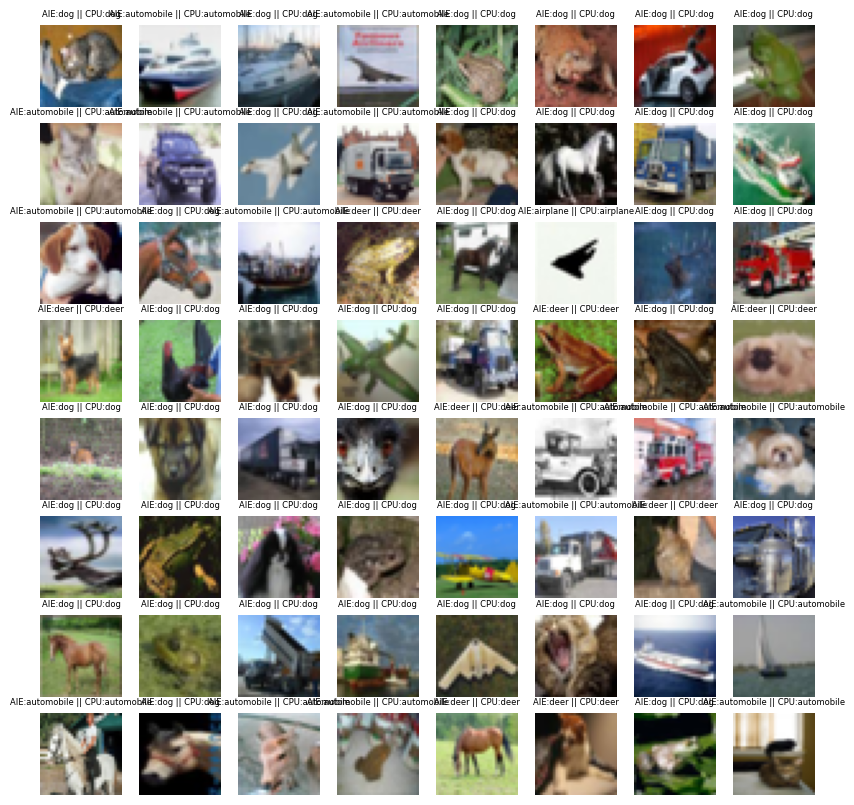

In [5]:
##### import matplotlib.pyplot as plt
import numpy as np
predicted_label=[None] * 64
cpu_predicted_label=[None] * 64
# input_batch = input_tensor.unsqueeze(0)
metafile = r'./data/cifar-10-batches-py/batches.meta'
datafile = r'./data/cifar-10-batches-py/test_batch'
data_batch_1 = unpickle(datafile) 
metadata = unpickle(metafile)
labels = data_batch_1['labels']
label_path="data/cifar10_label_map.txt"
model_num_classes=10
class_label_map = load_class_label(label_path, model_num_classes)
quant_id_1 = QuantIdentity(act_quant=Uint8ActPerTensorFixedPoint,bit_width=8, return_quant_tensor=True) 
quant_id_1.eval()
for i in range (0,64): 
    print("____________________________________IMAGE {}____________________________________________".format(i))
    image_name = f'./cifar_images/image_{i}.png'
    img = Image.open(image_name)     
    input_tensor = cifar_test_transform(img)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        # print(input_batch.shape)
        output1 = offload_model.first(input_batch)
       
        # AIE OFFLOAD
        qnt_inp = offload_model.aie.x_quant(output1)
        int_inp = offload_model.aie.x_quant(output1).int(float_datatype=True)
        before_input=int_inp.squeeze().data.numpy().astype(dtype_in)
        ifm_mem_fmt = ds.reorder_mat(before_input,'YCXC8' , 'CYX' )
        app.buffers[2].write(ifm_mem_fmt)# input's standard format CYX | scalar YCX
        app.buffers[3].write(total_wts) # wts's standard format OIYX | scalar OIYX
        app.run()
        
        output_aie= app.buffers[4].read()*block_0_relu_3
 
        temp_out    = output_aie.reshape(32,32,32,8)
        temp2_out   = ds.reorder_mat( temp_out, 'CDYX','YCXD' )
        ofm_mem_fmt = temp2_out.reshape(256,32,32)
        
        
        
        ofm_mem_fmt=torch.from_numpy(ofm_mem_fmt).unsqueeze(0)
        # output_aie_scaled=output_aie*block_1_relu_3
        # temp_out=output_aie_scaled.reshape(32,256, 32)
        # ofm_mem_fmt = temp_out.swapaxes(0,1) 

        # ------------------------------------------------------------------------------
        # Baseline output for functional correctness  
        output_golden = offload_model.aie(output1)
        # print(type(ofm_mem_fmt))
        # print(type(output_golden))
        max_error=(torch.max(torch.abs(ofm_mem_fmt - output_golden)))
        print(max_error)
        print("AIE::",ofm_mem_fmt)
        print("GOLDEN::",output_golden)
        assert(np.allclose(ofm_mem_fmt, output_golden, rtol=0, atol=2))
        # ------------------------------------------------------------------------------    

        final_output_aie = offload_model.post(ofm_mem_fmt)
        final_output_base = offload_model.post(output_golden)
        
        predicted_class = np.argmax(final_output_aie)
        predicted_label[i] = metadata['label_names'][predicted_class]

        cpu_predicted_class = np.argmax(final_output_base)
        cpu_predicted_label[i] = metadata['label_names'][cpu_predicted_class]

        label = metadata['label_names'][labels[i]]
        print(f' Predicted AIE: {predicted_label[i]}, Predicted CPU: {cpu_predicted_label[i]}') 

        
        # Calculate the five categories with the highest classification probability
        prediction_class_index = torch.topk(final_output_aie, k=5, sorted=True).indices.squeeze(0).tolist()
        golden_prediction_class_index = torch.topk(final_output_base, k=5, sorted=True).indices.squeeze(0).tolist()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(8, 8,figsize=(10,10))
for i, ax in enumerate(axs.flat):
    img = Image.open("./cifar_images/image_"+str(i)+".png")
    ax.imshow(img)
    ax.axis('off')  # to hide the axes
    ax.set_title("AIE:"+predicted_label[i]+" || CPU:"+predicted_label[i],fontsize=6)

    